In [1]:
from Bio.Align.Applications import ClustalOmegaCommandline 
from Bio.Cluster import kcluster 
from collections import Counter
from itertools import combinations

import os, sys

import numpy as np 
import pandas as pd

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [2]:
def makeFa(txt):
    
    # fa file to write. 
    out = os.path.splitext(txt)[0] + ".fa"

    # open write file
    writer = open(out, "w")
    
    # read txt file
    with open(txt, "r") as reader:
        for i, line in enumerate(reader):
            row = f">{i}\n{line}"
            writer.write(row)
    
    # close files
    writer.close(), reader.close()
    
    print('wrote', out)
    
    return out


def seqArray(sequence_list):
    """
    Return char array for str of sequences in list
    
    """
    seq_arrays = []
    for seq in sequence_list:
        seq_arrays.append([i for i in seq])
        
    return seq_arrays


def one_hot_encode(seq):
    mapping = dict(zip("ACGT", range(4)))    
    seq2 = [mapping[i] for i in seq]
    return np.eye(4)[seq2]

In [3]:
prefile = "/wynton/home/ahituv/fongsl/dna/hs1/kmers/15mers/SEED_15mer.firstorder.pam.purine.nohomopoly.GC.txt"  # fasta
onebpfile ="/wynton/home/ahituv/fongsl/dna/hs1/kmers/15mers/SEED_15mer.firstorder.pam.purine.nohomopoly.GC.1bpaway.identity.txt"
RE = "/wynton/home/ahituv/fongsl/nullomers/results/lock/"

In [4]:
sequence_nulls = Counter()
seq_pairs={}

# open the file
with open(onebpfile, "r") as reader:
    for i, line in enumerate(reader.readlines()):
        seq1, seq2, seqid = (((line.strip("\n")).strip("(")).strip(" ")).split(",")
        
        # count
        sequence_nulls[eval(seq1)]+=1 
        sequence_nulls[eval(seq2)]+=1
        
        seq_pairs[i]= pd.DataFrame([eval(seq1), eval(seq2)]).T
        
        

# pair counts

In [5]:
pairs = pd.concat(seq_pairs.values())

pairs["count"] = 1

pairs.head()

,0,1,count
0,CACGACTCGTTACGG,AACGACTCGTTACGG,1
0,CACGACTCGTTACGG,TACGACTCGTTACGG,1
0,CACGACTCGTTACGG,CACGAGTCGTTACGG,1
0,CGTATCGTACATCGG,CGTATCGTATATCGG,1
0,CGTATCGTACATCGG,CGTATCGTACAGCGG,1


# make set of nulls NOT related by 1bp

In [6]:
nulls = []
with open(prefile, "r") as reader:
    for i, line in enumerate(reader.readlines()):
        nulls.append(line.strip("\n"))


In [7]:
nulls = set(nulls)
related_nulls1, related_nulls2 = set(pairs[0]), set(pairs[1])

In [8]:
# subtract related sequences
nulls = nulls.difference(related_nulls1)
nulls = nulls.difference(related_nulls2)

In [9]:
nulls

{'CTGTCGCGATAACGG',
 'TCGATCGCGAAGTGG',
 'CATTATACGGCGCGG',
 'TTACTTTCGCGCGGG',
 'GTAATCTATCCGCGG',
 'CGAATACGAGACCGG',
 'GAATAACGTCGCGGG',
 'TGACCGGCTAAACGG',
 'ATCATCGCTAGCGGG',
 'CGTATTACGCGCTGG',
 'TAACCGTACCGGAGG',
 'ACGTCGCTATAGTGG',
 'CGAGATTCCGATCGG',
 'CGTTGACTAGATCGG',
 'ACTATCGACGCGAGG',
 'TCGCATCGAAACGGG',
 'GATCGTTGACGACGG',
 'AGCGTCGTATACGGG',
 'TATCGAGCCGTACGG',
 'TATTCGTCGCGTGGG',
 'CAATTACGACCGCGG',
 'GTCGCGTTCGATTGG',
 'ATAGGGCGCTAACGG',
 'CGATATACGCTAGGG',
 'AGTTGCGCCGTATGG',
 'CTAGTTGCGTACGGG',
 'AATCAACCGCGACGG',
 'CTAACACGACGACGG',
 'AATTTCGCCGCGAGG',
 'CGTACTTACTCGCGG',
 'TTTAACGGTGCGCGG',
 'TCGTCGTTACGCTGG',
 'GGTTCGGTGTATCGG',
 'TCCGATAGGTGTCGG',
 'ATTCGACTCGACGGG',
 'CTTCGTCGCGAATGG',
 'CTAACGAGCGAACGG',
 'CGCGTTCGATGAAGG',
 'TCGTGTATCGACGGG',
 'CGGCTAGTGTAACGG',
 'GATCTATTGCGACGG',
 'CGTTCGACGGAATGG',
 'ATGTCGTAAGCGCGG',
 'GCTCGTATAGGTCGG',
 'CAAGCGTTAAGCGGG',
 'TACCTAAACGGCGGG',
 'TGACGACACGATCGG',
 'GCAACGTATAGCCGG',
 'GCTCTATACGAGCGG',
 'GAACTATCTCGCCGG',


## sort nulls

In [16]:
df = pd.DataFrame(nulls)
df = df.sort_values(by=0)
nulls = list(df[0])

In [18]:
nulls_out = "/wynton/home/ahituv/fongsl/nullomers/results/lock/15mer.7771.fa"
with open(nulls_out, "w") as writer:
    for n, seq in enumerate(nulls):
        writer.write(f">{n}\n{seq}\n")
writer.close()

## seq_id of N= 7771 combinations

In [16]:
%%bash
du -h /wynton/home/ahituv/fongsl/nullomers/results/lock/seq_id_7771.txt

340M	/wynton/home/ahituv/fongsl/nullomers/results/lock/seq_id_7771.txt


In [17]:
out = os.path.join(RE, "seq_id_7771.txt")
if os.path.exists(out) is False:
    print("got to make this")
    # make combinations
    combos = combinations(nulls, 2)

    #measure seq identity of combinations
    identity = {}
    v = 0
    for seq1, seq2 in combos:
        identical = 0
        for i,j in zip(seq1, seq2):
            if i==j:
                identical+=1
        identity[v] = pd.DataFrame([seq1, seq2, identical]).T
        v+=1

    # save data as dataframe
    id_df = pd.concat(identity.values())

    print(id_df.shape)

    id_df.to_csv(out, sep='\t', index=False)
else:
    print("made this")
    id_df = pd.read_csv(out, sep='\t')

made this


In [19]:
id_df=id_df[1:]
id_df.head()

,0,1,2
1,AACCGTTTCGACGGG,TCGATATGCGCGAGG,5
2,AACCGTTTCGACGGG,CTAGTTGCGTACGGG,6
3,AACCGTTTCGACGGG,CGTACCCGGTTAAGG,2
4,AACCGTTTCGACGGG,CGAATCATACCGCGG,3
5,AACCGTTTCGACGGG,TAACCGCAATACGGG,7


In [33]:
means = id_df.groupby([0])[2].mean().reset_index()
means.columns = ['seq1', "mean1"]
std = id_df.groupby([0])[2].std().reset_index()
std.columns = ['seq1', "std1"]
means = pd.merge(means, std)
means["rank1"] = means["mean1"].rank()
means.sort_values(by="mean1")

,seq1,mean1,std1,rank1
5491,TAACGAACTCGCGGG,4.000000,NaN,1.0
2742,CGATCGCGCAATAGG,4.500000,2.121320,2.0
2584,CGACGTTCGTATGGG,4.750000,1.841442,3.5
2215,CCGAATTACGACGGG,4.750000,1.782960,3.5
1798,ATTACACGACGCGGG,4.758621,1.614739,5.0
...,...,...,...,...
6782,TCGTCTACGGAACGG,6.125000,2.474874,7470.0
3994,CTTCGTAGTCGTCGG,6.180233,1.759540,7471.0
5922,TAGCGCACCGATAGG,6.285714,0.951190,7472.0
6835,TCTACGCGCGAATGG,6.333333,2.309401,7473.0


In [34]:
means2 = id_df.groupby([1])[2].mean().reset_index()
means2.columns = ['seq2', "mean2"]
std = id_df.groupby([1])[2].std().reset_index()
std.columns = ['seq2', "std2"]
means2 = pd.merge(means2, std)
means2["rank2"] = means2["mean2"].rank()
means2.sort_values(by="mean2")

,seq2,mean2,std2,rank2
3815,CTATACGACCGATGG,4.000000,NaN,1.0
1245,AGTATTCGCGACGGG,4.482759,1.785271,2.0
3021,CGCGTTCTCGTATGG,4.746835,1.539800,3.0
747,ACGCGACGTCTAAGG,4.771429,1.681836,4.0
6930,TGATCGGGTCGATGG,4.833333,2.136976,5.0
...,...,...,...,...
7277,TTCAACGCGGAACGG,6.116667,1.708321,7469.0
1591,ATCGCAATACCACGG,6.153846,1.344504,7470.0
3643,CGTTCGAAGTGACGG,6.285714,1.815683,7471.0
3847,CTATCTTCGACGCGG,6.400000,2.302173,7472.0


In [35]:
means = pd.merge(means, means2, how="left", left_on="seq1", right_on="seq2")

In [37]:
means.sort_values(by = "rank1")

,seq1,mean1,std1,rank1,seq2,mean2,std2,rank2
5491,TAACGAACTCGCGGG,4.000000,NaN,1.0,TAACGAACTCGCGGG,5.094072,1.815310,591.0
2742,CGATCGCGCAATAGG,4.500000,2.121320,2.0,CGATCGCGCAATAGG,5.249063,1.836493,2186.0
2584,CGACGTTCGTATGGG,4.750000,1.841442,3.5,CGACGTTCGTATGGG,5.246562,1.847424,2172.0
2215,CCGAATTACGACGGG,4.750000,1.782960,3.5,CCGAATTACGACGGG,5.159935,1.796676,1369.0
1798,ATTACACGACGCGGG,4.758621,1.614739,5.0,ATTACACGACGCGGG,5.080636,1.814744,458.0
...,...,...,...,...,...,...,...,...
6782,TCGTCTACGGAACGG,6.125000,2.474874,7470.0,TCGTCTACGGAACGG,5.837932,1.746411,7187.0
3994,CTTCGTAGTCGTCGG,6.180233,1.759540,7471.0,CTTCGTAGTCGTCGG,5.717612,1.766220,5616.0
5922,TAGCGCACCGATAGG,6.285714,0.951190,7472.0,TAGCGCACCGATAGG,5.288469,1.794515,2420.0
6835,TCTACGCGCGAATGG,6.333333,2.309401,7473.0,TCTACGCGCGAATGG,5.327258,1.844106,2567.0


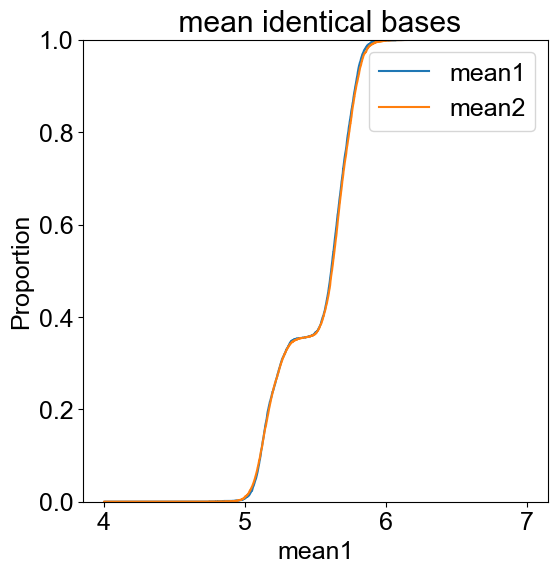

In [63]:
fig, ax=plt.subplots(figsize=(6,6))
sns.ecdfplot(x="mean1", data=means, label="mean1")
sns.ecdfplot(x="mean2", data=means, label="mean2")
ax.set(title = " mean identical bases")
ax.legend()

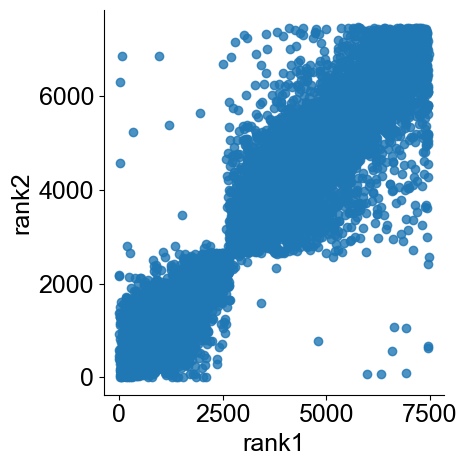

In [39]:
sns.lmplot(x="rank1", y="rank2", data=means)

# pick 1000 nullomers, least related

In [114]:
cutoff= 5.108
cutoffdf = means.loc[(means.mean1<=cutoff) | (means.mean2<=cutoff)].copy()
print(cutoffdf.shape)

indexes, seqs = cutoffdf.index, cutoffdf.seq1

(1002, 8)


In [115]:
seqs

18      AAACGTCGCGTAGGG
22      AAACTCGACGACGGG
25      AAACTCGTCGCGAGG
27      AAAGCGATACGCGGG
35      AAATACGTGCGCGGG
             ...       
7295    TTCCGACGAACGAGG
7297    TTCCGCGATACGTGG
7330    TTGACGCGCATAGGG
7365    TTGCGTCGAACGAGG
7388    TTGTAAACGCGCGGG
Name: seq1, Length: 1002, dtype: object

# label encoder

In [64]:
related_nulls=list(rel["seq"])

In [19]:
nulls

['AAACCGAGCGATCGG',
 'AAACCGCGCTTACGG',
 'AAACCGCTATACCGG',
 'AAACCGGTTACGCGG',
 'AAACCGTTCGATCGG',
 'AAACGACCGTGTCGG',
 'AAACGAGCGGATCGG',
 'AAACGATCGGGTCGG',
 'AAACGATCTGCGCGG',
 'AAACGATTCGAGCGG',
 'AAACGCACCGTACGG',
 'AAACGCGACGAAGGG',
 'AAACGCGATATACGG',
 'AAACGCGCCTTACGG',
 'AAACGCGCTTACCGG',
 'AAACGGTCGAGTCGG',
 'AAACGGTCTAACCGG',
 'AAACGTAGGTCGCGG',
 'AAACGTCGCGGTAGG',
 'AAACGTCGCGTAGGG',
 'AAACGTCGCTAGCGG',
 'AAACGTCTCGCGTGG',
 'AAACTACGTACGCGG',
 'AAACTCGACGACGGG',
 'AAACTCGATCGGCGG',
 'AAACTCGCATACCGG',
 'AAACTCGTCGCGAGG',
 'AAACTTCGACGACGG',
 'AAAGCGATACGCGGG',
 'AAAGCGATCGACCGG',
 'AAAGCGTTACGGCGG',
 'AAAGCTTCGCGTCGG',
 'AAAGGGTCGATACGG',
 'AAAGTACGACGTCGG',
 'AAAGTACGTCGCCGG',
 'AAAGTCCGATCGCGG',
 'AAATACGTGCGCGGG',
 'AAATAGCGTCGCGGG',
 'AAATATCGCGCACGG',
 'AAATCCCGTCGACGG',
 'AAATCCGTGCGACGG',
 'AAATCGACGCGAAGG',
 'AAATCGCGCGGTTGG',
 'AAATCGTATCGCCGG',
 'AAATCGTCGAAGCGG',
 'AAATCGTCGACGAGG',
 'AAATCTTCGCGCGGG',
 'AAATGTCGACCGCGG',
 'AAATTACGCCGCCGG',
 'AAATTCGGGCGACGG',


In [26]:
def labelEncoder(seq_list):
    encoded = []
    le = LabelEncoder()
    le.fit(["A", "C", "T", "G"])

    for n, seq in enumerate(seq_list):
        encoded.append(le.transform([i for i in seq]))


    X = np.array(encoded)
    
    return X

In [27]:
X = labelEncoder(nulls)

## randomly sample nullomers

In [46]:
nulls_out_fa = "/wynton/home/ahituv/fongsl/nullomers/results/lock/15mer.7771.sample1000.fa"
nulls_out_txt = "/wynton/home/ahituv/fongsl/nullomers/results/lock/15mer.7771.sample1000.txt"

if os.path.exists(nulls_out_fa) is False:
    sample_nulls = np.random.choice(nulls, size=1000, replace = False)

# write fa    
with open(nulls_out_fa, "w") as writer:
    for n, seq in enumerate(sample_nulls):
        writer.write(f">{n}\n{seq}\n")
writer.close()

# write txt
with open(nulls_out, "w") as writer:
    for n, seq in enumerate(sample_nulls):
        writer.write(f"{seq}\n")
writer.close()

In [28]:
Xs = labelEncoder(sample_nulls)

# sklearn kmeans w randomsearch CV

## one hot encode

In [ ]:
def oneHot(sequence_nulls):

    arrays = []

    for n, seq in enumerate(sequence_nulls):
        onehot = one_hot_encode(seq)
        arrays.append(onehot.ravel().astype(float))

    X = np.array(arrays) 
    
    return X

## train test split

In [20]:
X_train, X_test= train_test_split(X)

## PCA

first 30 components explain 95% of data

In [30]:
pca = PCA(n_components=0.95)

Xt = pca.fit_transform(X)

print(pca.explained_variance_ratio_.sum())
pca.explained_variance_ratio_, len(pca.explained_variance_ratio_)

0.9599253849341255


(array([0.11032101, 0.10348936, 0.09767874, 0.09662312, 0.08951923,
        0.08331135, 0.07781244, 0.07085356, 0.0635246 , 0.06160677,
        0.05620821, 0.04897698]),
 12)

In [31]:
pca_s = PCA(n_components=0.95)

Xst = pca_s.fit_transform(Xs)

print(pca_s.explained_variance_ratio_.sum())
pca_s.explained_variance_ratio_, len(pca_s.explained_variance_ratio_)

0.9597027102197276


(array([0.11787291, 0.11085006, 0.09795411, 0.09443341, 0.09253876,
        0.07938179, 0.0752992 , 0.06864094, 0.06086865, 0.05915787,
        0.05358506, 0.04911995]),
 12)

In [32]:
plotdf = pd.DataFrame(pca.explained_variance_ratio_).reset_index()

plotdf["index"] = plotdf["index"]+1

plotdf["cumsum"] = plotdf[0].cumsum()

plotdf

,index,0,cumsum
0,1,0.110321,0.110321
1,2,0.103489,0.213810
2,3,0.097679,0.311489
3,4,0.096623,0.408112
4,5,0.089519,0.497631
5,6,0.083311,0.580943
6,7,0.077812,0.658755
7,8,0.070854,0.729609
8,9,0.063525,0.793133
9,10,0.061607,0.854740


In [33]:
plotdfs = pd.DataFrame(pca_s.explained_variance_ratio_).reset_index()

plotdfs["index"] = plotdfs["index"]+1

plotdfs["cumsum"] = plotdfs[0].cumsum()

plotdfs

,index,0,cumsum
0,1,0.117873,0.117873
1,2,0.110850,0.228723
2,3,0.097954,0.326677
3,4,0.094433,0.421110
4,5,0.092539,0.513649
5,6,0.079382,0.593031
6,7,0.075299,0.668330
7,8,0.068641,0.736971
8,9,0.060869,0.797840
9,10,0.059158,0.856998


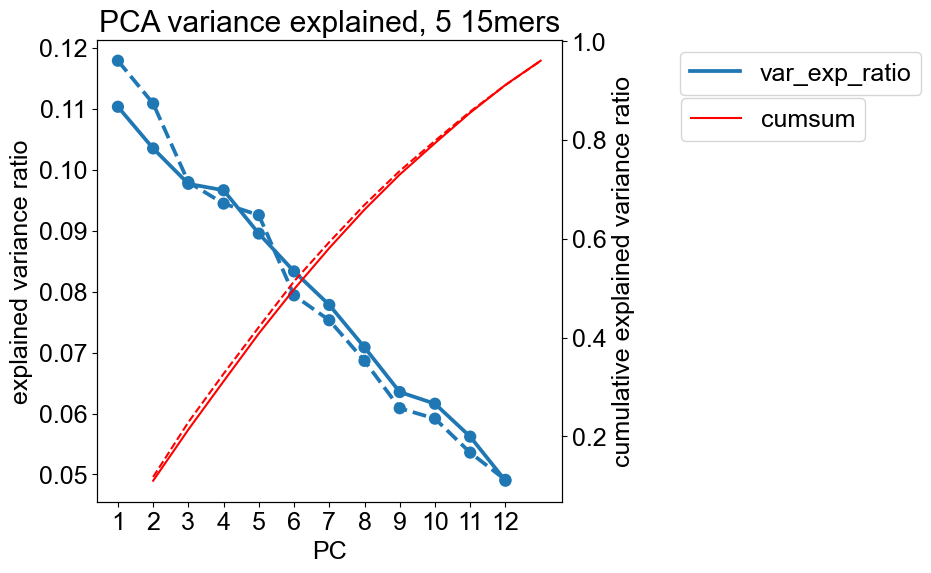

In [48]:
fig, ax=plt.subplots(figsize=(6,6))
x="index"
data=plotdf
data2=plotdfs

sns.pointplot(x=x, y=0, data=data, ax = ax)
sns.pointplot(x=x, y=0, data=data2, ax = ax, linestyles="--")
ax.set(xlabel = "PC", 
       ylabel = "explained variance ratio",
       title= f"PCA variance explained, {len(x)} 15mers",
       
      )
ax.legend(["var_exp_ratio"], bbox_to_anchor=(1.8, 1))
ax2 = ax.twinx()

sns.lineplot(x=x, y="cumsum", data=data, color="r", ax=ax2)
sns.lineplot(x=x, y="cumsum", data=data2, color="r", ax=ax2, ls="--")
ax2.set(xlabel = "PC", 
       ylabel = "cumulative explained variance ratio"
      )
ax2.legend(["cumsum"], bbox_to_anchor=(1.68,0.9))
plt.savefig(os.path.join(RE, f"15mer_unrelated.PCA.scree_pop_sample.pdf"), bbox_inches="tight")

/scratch/fongsl/ipykernel_2475/3831905948.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(np.array(Xt)[:,0], np.array(Xt)[:,1],
/scratch/fongsl/ipykernel_2475/3831905948.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax2.scatter(np.array(Xst)[:,0], np.array(Xst)[:,1],


[Text(0.5, 0, 'PC1-0.118'),
 Text(0, 0.5, 'PC2-0.111'),
 Text(0.5, 1.0, 'label encoded sequence PCA\n1K SAMPLED')]

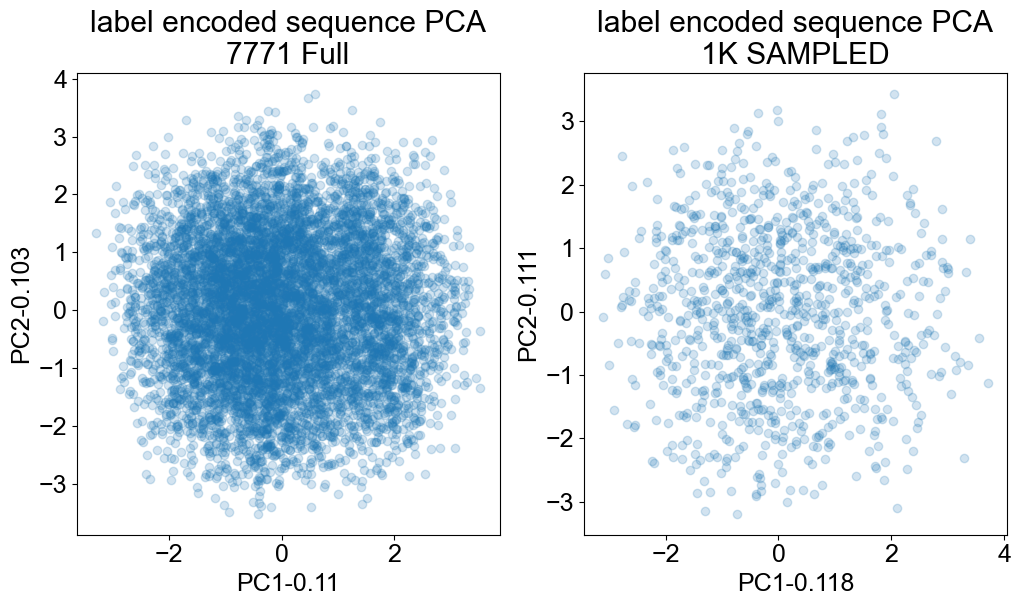

In [54]:
fig, (ax, ax2)= plt.subplots(ncols =2, figsize=(12,6))
ax.scatter(np.array(Xt)[:,0], np.array(Xt)[:,1],  
            #c=(y["label"]),
            cmap="bwr", alpha=0.2)
ax.set(xlabel=f"PC1-{round(pca.explained_variance_ratio_[0],3)}",
       ylabel=f"PC2-{round(pca.explained_variance_ratio_[1],3)}",
       title="label encoded sequence PCA\n7771 Full"
)


ax2.scatter(np.array(Xst)[:,0], np.array(Xst)[:,1],  
            #c=(y["label"]),
            cmap="bwr", alpha=0.2)
ax2.set(xlabel=f"PC1-{round(pca_s.explained_variance_ratio_[0],3)}",
       ylabel=f"PC2-{round(pca_s.explained_variance_ratio_[1],3)}",
       title="label encoded sequence PCA\n1K SAMPLED"
)

## cluster PCA

In [124]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    r = dendrogram(linkage_matrix, **kwargs)
    
    return r, linkage_matrix

## dendrogram-PCA

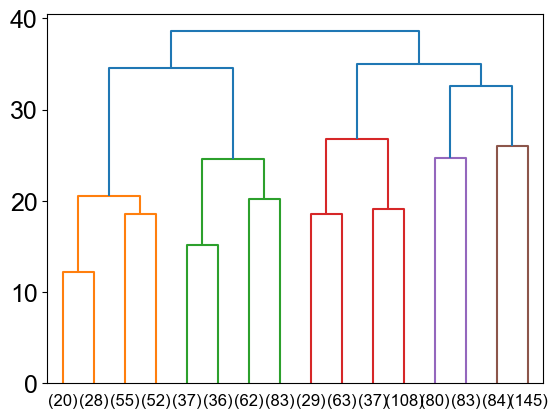

In [125]:
# make PC dataframe
df = pd.DataFrame(Xt)

test = df


model = AgglomerativeClustering(n_clusters=len(pca.explained_variance_ratio_), compute_distances=True)
model.fit_predict(test.to_numpy())
test["PCA_label"] = model.labels_
#

results, lm = plot_dendrogram(model, truncate_mode="level", p=3)

##  encoded dendrogram

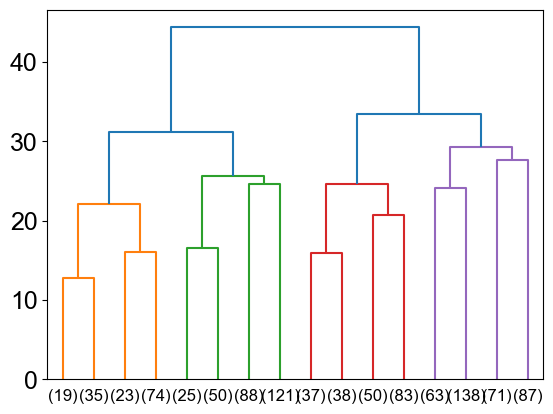

In [126]:
# make PC dataframe
df = pd.DataFrame(X)


test = df

model = AgglomerativeClustering(n_clusters=len(pca.explained_variance_ratio_), compute_distances=True)
model.fit_predict(test.to_numpy())
df["agglo_label"] = model.labels_

#

results, lm = plot_dendrogram(model, truncate_mode="level", p=3)

In [127]:
df 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,agglo_label
0,0,0,0,1,2,3,1,2,1,2,3,0,2,2,2,4
1,0,0,0,1,3,1,2,0,1,2,0,1,2,2,2,9
2,0,0,0,1,3,1,2,3,1,2,1,2,0,2,2,0
3,0,0,0,2,1,2,0,3,0,1,2,1,2,2,2,0
4,0,0,0,3,0,1,2,3,2,1,2,1,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,3,3,1,1,2,0,1,2,0,0,1,2,0,2,2,10
998,3,3,1,1,2,1,2,0,3,0,1,2,3,2,2,6
999,3,3,2,0,1,2,1,2,1,0,3,0,2,2,2,3
1000,3,3,2,1,2,3,1,2,0,0,1,2,0,2,2,10


In [128]:
df.groupby("agglo_label")[0].count()

agglo_label
0     121
1     138
2      75
3      88
4      87
5      50
6      83
7      97
8      75
9      63
10     54
11     71
Name: 0, dtype: int64

In [129]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,agglo_label
0,0,0,0,1,2,3,1,2,1,2,3,0,2,2,2,4
1,0,0,0,1,3,1,2,0,1,2,0,1,2,2,2,9
2,0,0,0,1,3,1,2,3,1,2,1,2,0,2,2,0
3,0,0,0,2,1,2,0,3,0,1,2,1,2,2,2,0
4,0,0,0,3,0,1,2,3,2,1,2,1,2,2,2,1


In [130]:
import matplotlib

In [131]:
cmap = matplotlib.cm.get_cmap('Set3')

/scratch/fongsl/ipykernel_45310/1383955161.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Set3')


In [132]:
#lut = dict(zip(test["label"].unique(), "rbg"))
lut = dict(zip(df["agglo_label"].unique(), cmap.colors))
row_colors = df["agglo_label"].map(lut)

In [133]:
df[df.columns[:-1]]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,1,2,3,1,2,1,2,3,0,2,2,2
1,0,0,0,1,3,1,2,0,1,2,0,1,2,2,2
2,0,0,0,1,3,1,2,3,1,2,1,2,0,2,2
3,0,0,0,2,1,2,0,3,0,1,2,1,2,2,2
4,0,0,0,3,0,1,2,3,2,1,2,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,3,3,1,1,2,0,1,2,0,0,1,2,0,2,2
998,3,3,1,1,2,1,2,0,3,0,1,2,3,2,2
999,3,3,2,0,1,2,1,2,1,0,3,0,2,2,2
1000,3,3,2,1,2,3,1,2,0,0,1,2,0,2,2


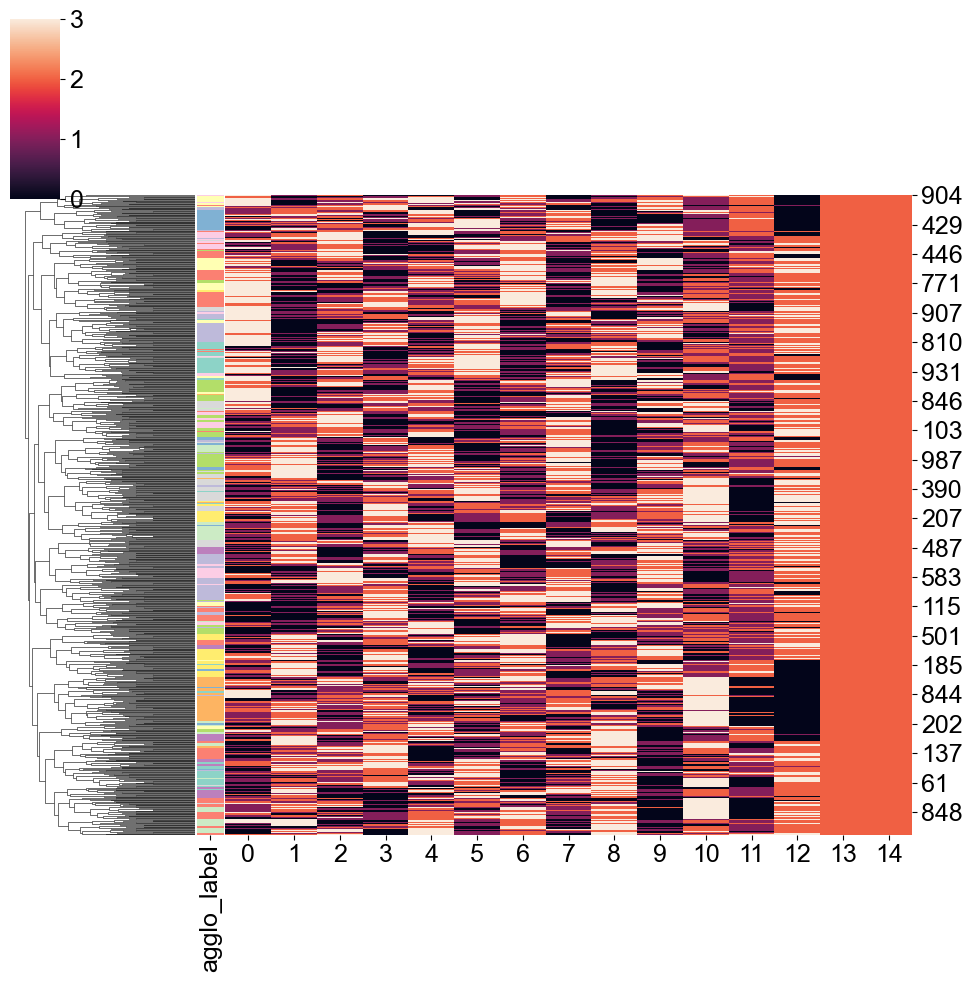

In [134]:
sns.clustermap(test[df.columns[:-1]], row_colors=row_colors, col_cluster=False)
plt.savefig(os.path.join(RE, f"15mer.agglo.clustermap.pdf"), bbox_inches="tight")

# Kmeans w/ PCA

In [ ]:
model = KMeans(n_clusters=len(pca.explained_variance_ratio_))

# fit the model
model.fit(X)

In [ ]:
labeldf = pd.DataFrame(zip(sequence_nulls, model.labels_), columns = ["null", "label"])
labeldf.head()

In [ ]:
labeldf.groupby("label")["null"].count()

# hamming

In [ ]:
from scipy.spatial.distance import pdist
from itertools import combinations

In [ ]:
h = labeldf.sort_values(by="label").head()
hseq = list(h["null"])

hseq = np.array(hseq)
hseq

In [ ]:


t = labeldf.sort_values(by="label").tail()
tseq = list(t["null"])
print(len(tseq))

tseq=np.array(tseq)
tseq

In [ ]:
x = np.column_stack([hseq, tseq])
x

In [ ]:
pdist(x, method="hamming")

In [ ]:
labeldf.loc[labeldf["label"]==3, ""].sample(n=100)

In [ ]:
t = labeldf.loc[labeldf["label"]==3]
distances = {}
v=0
cat = labeldf.loc[labeldf["label"]==3].sample(n=100)
for i,j in combinations(cat, 2):

    hdist = hamming(list(i),list(j))
    distances[v]=np.array([i,j,hdist])
    if hdist<0.15:
        print(np.array([i,j,hdist]))


In [ ]:
distances = {}
v=0
cat = tseq
for i,j in combinations(cat, 2):

    hdist = hamming(list(i),list(j))
    distances[v]=np.array([i,j,hdist])
    print(np.array([i,j,hdist]))


In [ ]:
distances = {}
v=0
cat = hseq+tseq
#for i,j in combinations(cat, 2):
for i, j in zip(hseq, tseq):

    hdist = hamming(list(i),list(j))
    distances[v]=np.array([i,j,hdist])
    print(np.array([i,j,hdist]))


In [ ]:
hamming(["s", "f", "o"],["s", "f", "o"] )
